In [1]:
import torch
import pandas as pd
import torch.nn as nn
import torch.optim as optim

from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader

In [2]:
# Create dataset and dataloader
class CoordinateDataset(Dataset):
    def __init__(self, data_dir):
        self.data = pd.read_csv(data_dir)
        self.x, self.y = self.__processing()

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx] # Se regresa un registro de datos junto con su etiqueta

    def __len__(self):
        return len(self.data)

    def __processing(self):
        i, o = self.data[['x', 'y', 'z']].to_numpy(), self.data[['class']].to_numpy()
        return torch.from_numpy(i).float(), torch.from_numpy(o).float()  


In [3]:
# Configuration
BATCH_SIZE = 2048
EPOCHS = 100
LEARNING_RATE = 0.001
ROPE_DIM = 128   # Dimension for each coordinate's RoPE embedding
LINEAR_DIM = 256 # Dimension for each linear layer

TRAIN_PATH_DATASET = 'data/csv/data_class/train.csv'
VAL_PATH_DATASET = 'data/csv/data_class/val.csv'

train_dataset = CoordinateDataset(TRAIN_PATH_DATASET)
val_dataset = CoordinateDataset(VAL_PATH_DATASET)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False) 
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False) 

In [4]:
def pt_module_parameters(module):
    """ Retorna la cantidad de parametros del modulo pytorch """
    pp=0
    for p in list(module.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

In [5]:
# Rotary Position Embedding (RoPE) module
class RoPE(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
        inv_freq = torch.logspace(0, 3, dim//2) #Valores que multiplican al angulo van desde 1 a 1000 en escala logaritmica
        self.register_buffer('inv_freq', inv_freq)

    def forward(self, x):
        # x shape: (batch_size, 2) containing (x, y) coordinates
        x_coords = x[:, 0]
        y_coords = x[:, 1]
        z_coords = x[:, 2]
        
        x_embed = self._embed_single(x_coords)
        y_embed = self._embed_single(y_coords)
        z_embed = self._embed_single(z_coords)
        return torch.cat([x_embed, y_embed, z_embed], dim=1)

    def _embed_single(self, pos):
        # pos shape: (batch_size,)
        angles = pos.unsqueeze(-1) * self.inv_freq.unsqueeze(0)
        sin = torch.sin(angles)
        cos = torch.cos(angles)
        
        # Interleave sin and cos values
        embed = torch.stack([sin, cos], dim=-1)
        return embed.view(embed.size(0), -1)

In [6]:
# Neural network architecture
class ColorNetRope(nn.Module):
    def __init__(self):
        super().__init__()
        self.rope = RoPE(ROPE_DIM)
        self.layers = nn.Sequential(
            nn.Linear(3 *ROPE_DIM, LINEAR_DIM),
            nn.GELU(), 
            nn.Linear(LINEAR_DIM, LINEAR_DIM),
            nn.GELU(),
            nn.Linear(LINEAR_DIM, LINEAR_DIM),
            nn.GELU(),
            nn.Linear(LINEAR_DIM, 4),
            nn.Softmax(dim=1)
            #nn.Sigmoid()
        )

    def forward(self, x):
        x = self.rope(x)
        return self.layers(x)

In [7]:
# Initialize model, loss, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# model = ColorNet().to(device)
model = ColorNetRope().to(device)
#criterion = nn.MSELoss()

optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=LEARNING_RATE*0.1)

print(f"Model Parameters: {pt_module_parameters(model)}")

Model Parameters: 231172


In [8]:
def pt_bce2(yp, yt, eps=1e-8):
    """ Binary Cross Entropy con recorte entre eps y 1-eps para evitar errores numericos en el logaritmo. Retorna un tensor con la misma forma que yp """
    epsc = 1-eps
    yp  = torch.clip(yp,eps,epsc)
    ypc = torch.clip(1-yp,eps,epsc)
    loss = yt*torch.log(yp)+(1-yt)*torch.log(ypc)
    return -loss

def pt_loss_mbce2(yp, yt, eps=1e-8):    
    """ Mean Binary Cross Entropy con recorte entre eps y 1-eps para evitar errores numericos en el logaritmo. Retorna un scalar  """
    return pt_bce2(yp, yt, eps).mean()

In [9]:
# # Training loop
# train_loss = []
# for epoch in range(EPOCHS):
#     epoch_loss = 0.0
#     progress_bar = tqdm(train_dataloader, desc=f'Epoch {epoch+1}/{EPOCHS}', leave=False)
#     for inputs, targets in progress_bar:
#         inputs, targets = inputs.to(device), targets.to(device)
#         optimizer.zero_grad()
#         outputs = model(inputs)
#         loss = pt_loss_mbce2(outputs, targets)
#         loss.backward()
#         optimizer.step()
#         epoch_loss += loss.item() * inputs.size(0)
#         progress_bar.set_postfix(loss=loss.item(), lr=scheduler.get_last_lr()[0])
#     scheduler.step()
#     epoch_loss /= len(train_dataset)
#     train_loss.append(epoch_loss)
#     print(f'Epoch {epoch+1}/{EPOCHS} - Loss: {epoch_loss:.6f} LR: {scheduler.get_last_lr()[0]:.6f}')

In [10]:
import torch
from tqdm import tqdm

# Validation loop
def validate(model, dataloader, device):
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    with torch.no_grad():  # Disable gradient calculation
        for inputs, targets in tqdm(dataloader, desc='Validation', leave=False):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = pt_loss_mbce2(outputs, targets)
            val_loss += loss.item() * inputs.size(0)
    val_loss /= len(dataloader.dataset)
    return val_loss


# Training and validation loop
train_loss = []
val_loss = []
best_val_loss = float('inf')
patience = 5  # Number of epochs to wait for improvement
patience_counter = 0
save_path = 'best_model.pth'

for epoch in range(EPOCHS):
    epoch_loss = 0.0
    progress_bar = tqdm(train_dataloader, desc=f'Epoch {epoch+1}/{EPOCHS}', leave=False)
    model.train()  # Set the model to training mode
    for inputs, targets in progress_bar:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = pt_loss_mbce2(outputs, targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * inputs.size(0)
        progress_bar.set_postfix(loss=loss.item(), lr=scheduler.get_last_lr()[0])
    scheduler.step()
    epoch_loss /= len(train_dataset)
    train_loss.append(epoch_loss)

    # Validate the model
    val_epoch_loss = validate(model, val_dataloader, device)
    val_loss.append(val_epoch_loss)

    print(f'Epoch {epoch+1}/{EPOCHS} - Train Loss: {epoch_loss:.6f} - Val Loss: {val_epoch_loss:.6f} - LR: {scheduler.get_last_lr()[0]:.6f}')

    # Save the model if it has the best validation loss
    if val_epoch_loss < best_val_loss:
        best_val_loss = val_epoch_loss
        torch.save(model.state_dict(), save_path)
        patience_counter = 0
    else:
        patience_counter += 1

    # Early stopping
    if patience_counter >= patience:
        print(f'Early stopping at epoch {epoch+1}')
        break

# Load the best model
model.load_state_dict(torch.load(save_path))
print(f'Best model loaded from {save_path}')

Epoch 1/100 - Train Loss: 0.952144 - Val Loss: 1.079978 - LR: 0.001000


Epoch 2/100 - Train Loss: 0.952143 - Val Loss: 1.079977 - LR: 0.000999


Epoch 3/100 - Train Loss: 0.952143 - Val Loss: 1.079978 - LR: 0.000998


Epoch 4/100 - Train Loss: 0.952143 - Val Loss: 1.079977 - LR: 0.000996


Epoch 5/100 - Train Loss: 0.952143 - Val Loss: 1.079977 - LR: 0.000994


Epoch 6/100 - Train Loss: 0.952143 - Val Loss: 1.079977 - LR: 0.000992


Epoch 7/100 - Train Loss: 0.952143 - Val Loss: 1.079977 - LR: 0.000989


Epoch 8/100 - Train Loss: 0.952143 - Val Loss: 1.079977 - LR: 0.000986


Epoch 9/100 - Train Loss: 0.952143 - Val Loss: 1.079977 - LR: 0.000982


Epoch 10/100 - Train Loss: 0.952143 - Val Loss: 1.079977 - LR: 0.000978


Epoch 11/100 - Train Loss: 0.952143 - Val Loss: 1.079977 - LR: 0.000973
Early stopping at epoch 11
Best model loaded from best_model.pth


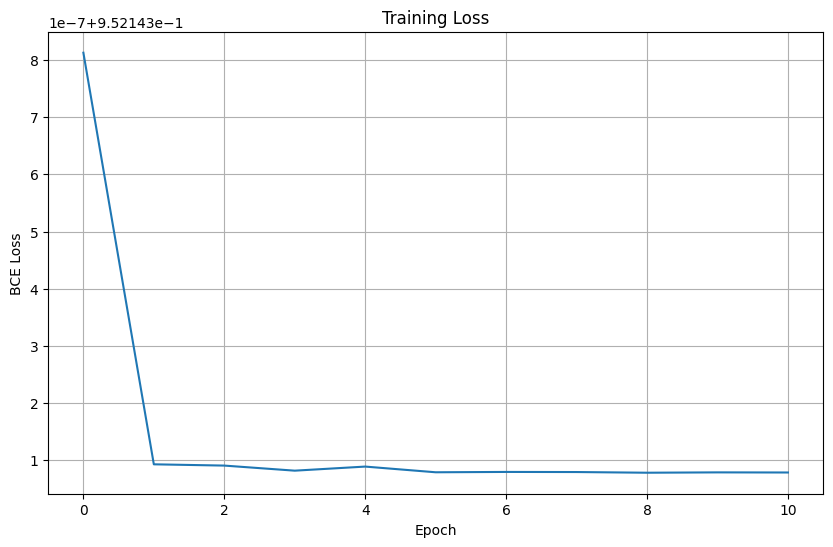

In [11]:
import matplotlib.pyplot as plt

# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(train_loss)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('BCE Loss')
plt.grid(True)
plt.show()